In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, math

In [114]:
NUMBER_OF_CORES = 8

file2_scalable = pd.read_csv("openmp_sorting/results_scalable.txt")
file2_nonscalable = pd.read_csv("openmp_sorting/results_non-scalable.txt")
file3_scalable = pd.read_csv("openmp_sorting/results_merging_scalable.txt")
file3_nonscalable = pd.read_csv("openmp_sorting/results_merging_non-scalable.txt")

In [115]:
def plot_time(data_file_2, data_file_3, number_of_points, number_of_buckets, range_of_numbers, if_scalable):
    query = 'number_of_points==' + str(number_of_points) + ' & number_of_buckets==' + str(number_of_buckets) + ' & range_of_numbers==' + str(range_of_numbers)
    filtered_data_2 = data_file_2.query(query)['time'].values
    filtered_data_3 = data_file_3.query(query)['time'].values
    
    plt.plot(np.arange(2, NUMBER_OF_CORES+1), filtered_data_2[1:])
    plt.plot(np.arange(2, NUMBER_OF_CORES+1), filtered_data_3[1:])

    plt.plot()
    plt.xlabel("Number of cores")
    plt.ylabel("Execution time (s)")
    plt.title("EXECUTION TIME" + "\n Number of points: " + str(number_of_points) +  "\n Number of buckets: " + str(number_of_buckets) + "\n Range of numbers: " + str(range_of_numbers) + "\n"+ if_scalable)
    plt.legend(["Algorithm 2", "Algorithm 3"])
    plt.show()

In [116]:
# plot_time(file2_scalable, file3_scalable, 1000000, 100, 100, "scalable")

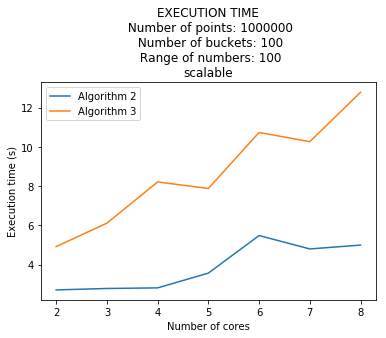

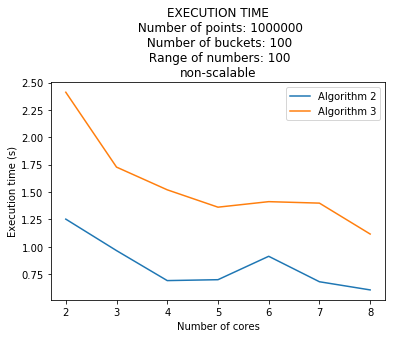

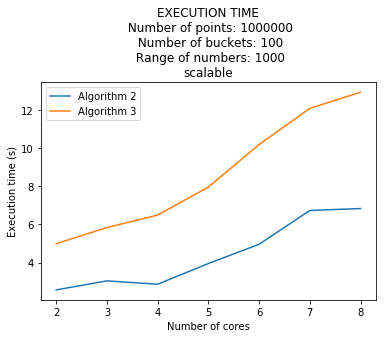

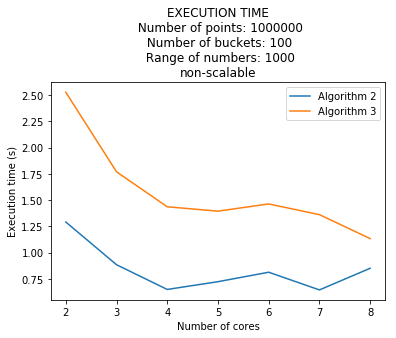

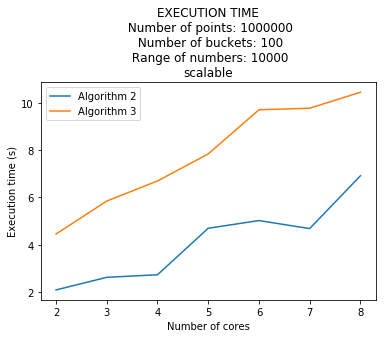

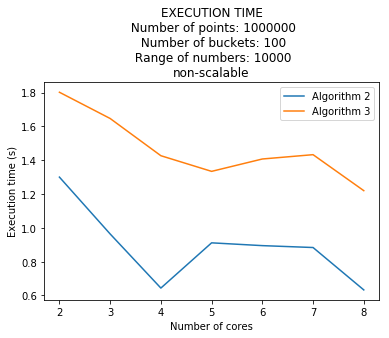

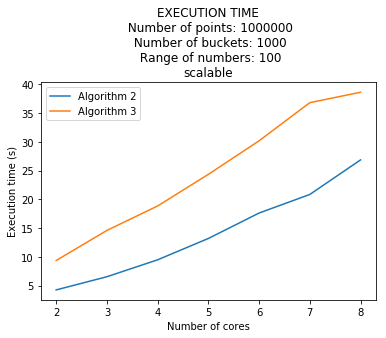

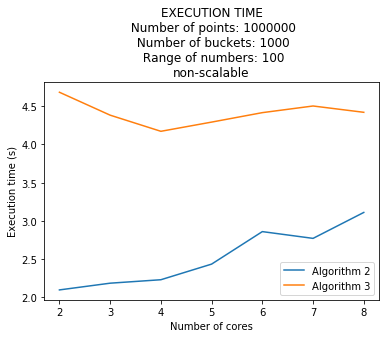

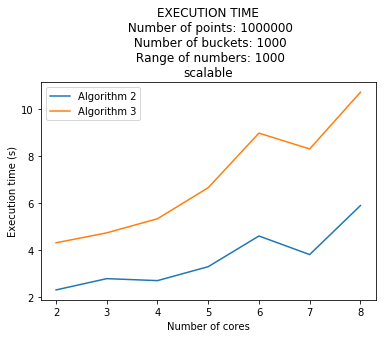

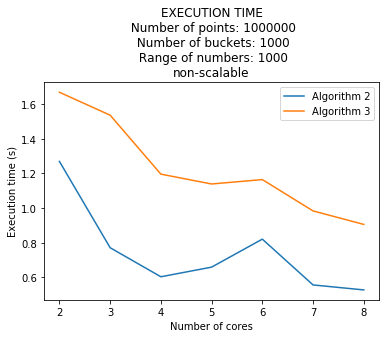

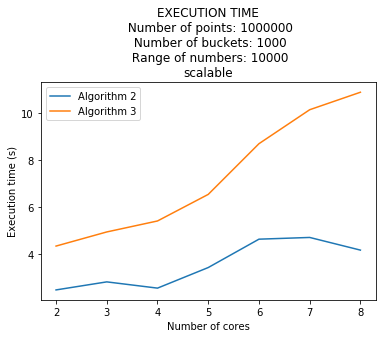

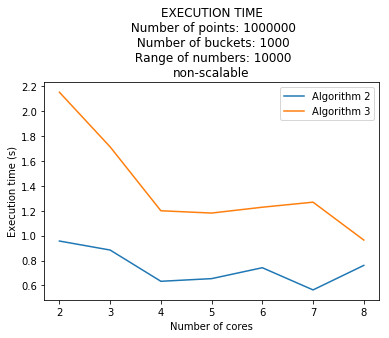

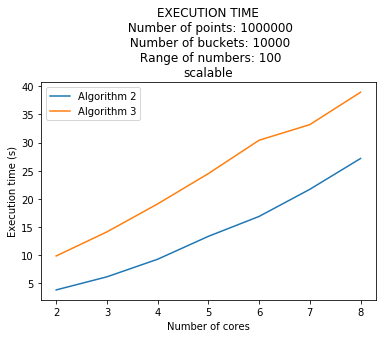

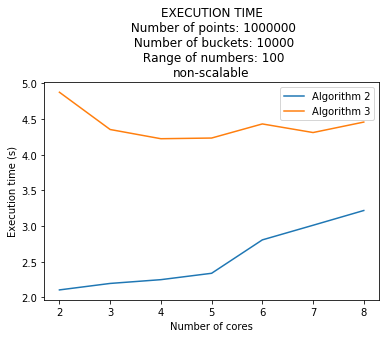

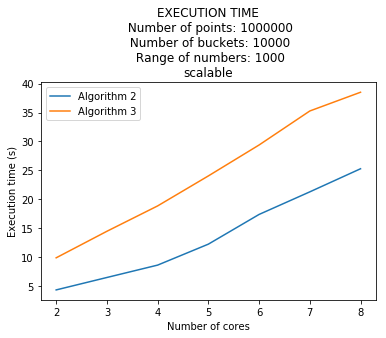

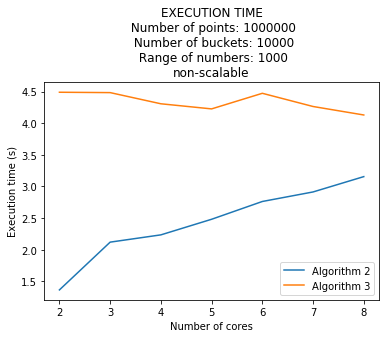

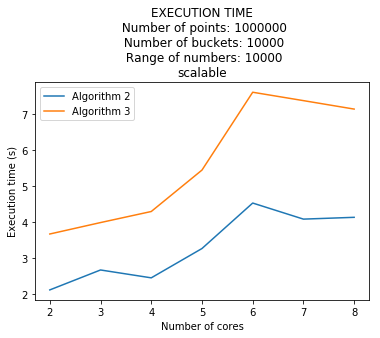

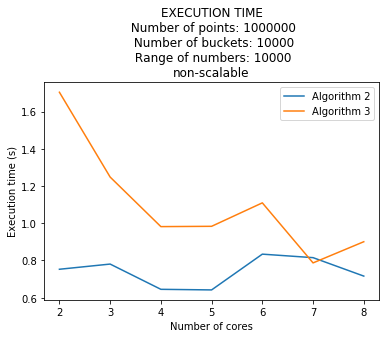

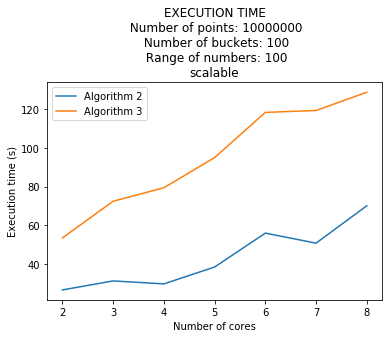

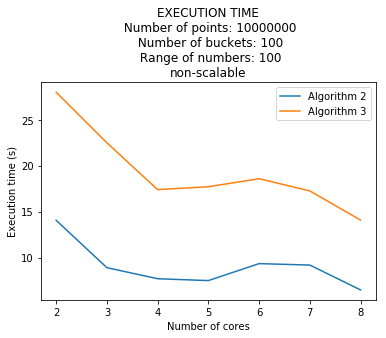

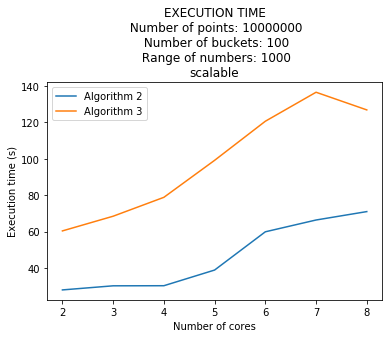

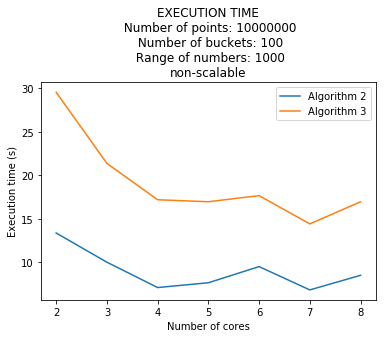

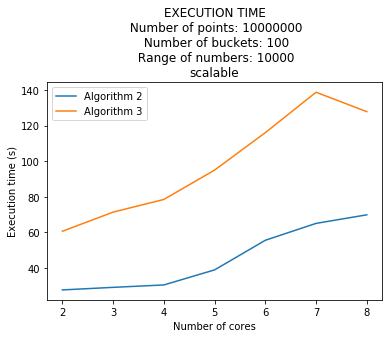

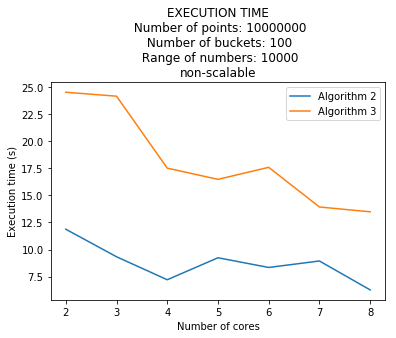

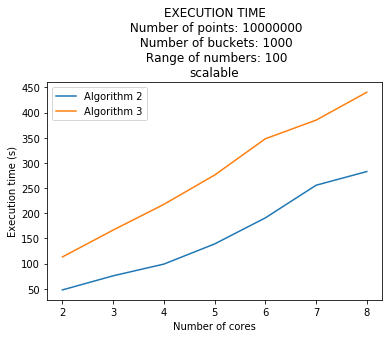

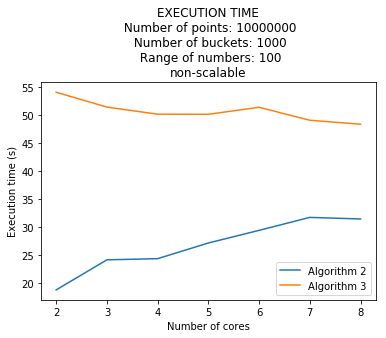

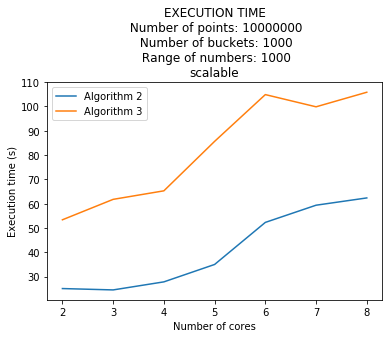

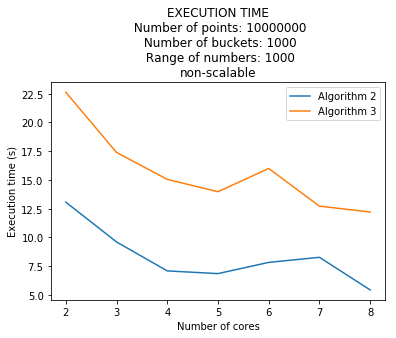

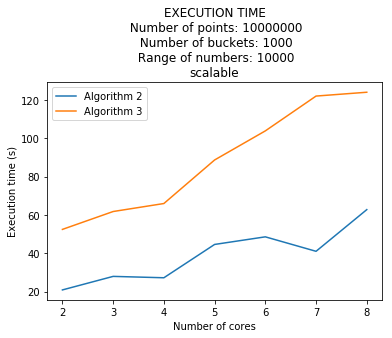

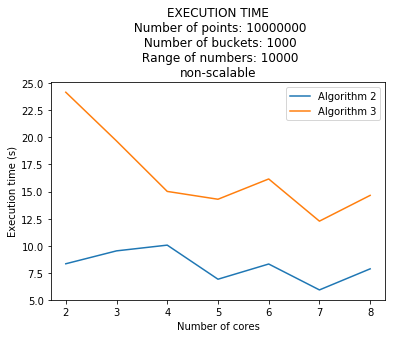

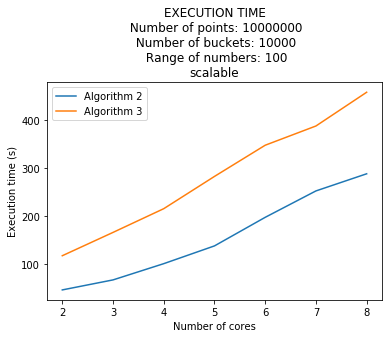

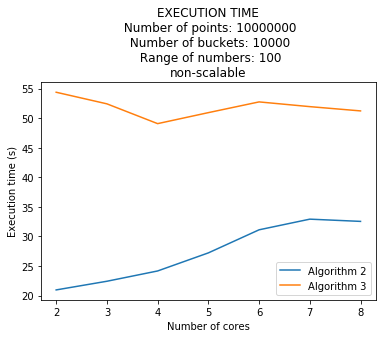

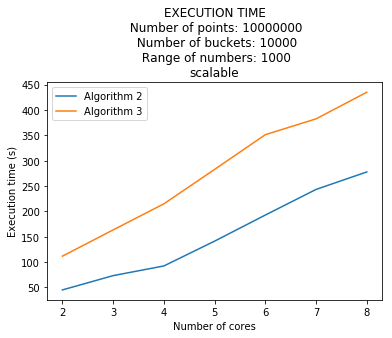

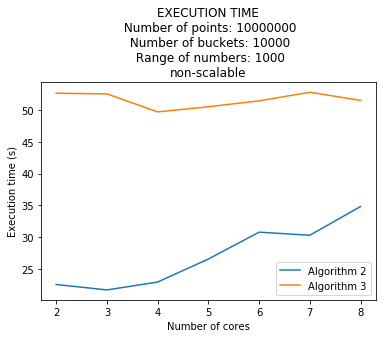

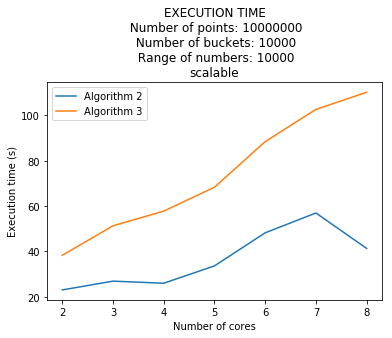

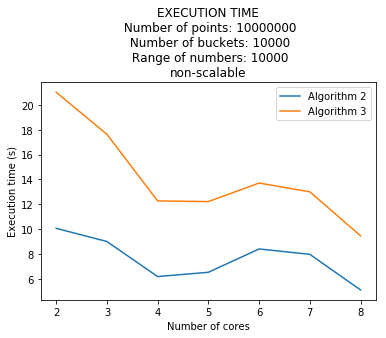

In [117]:
points = [1000000,10000000]
buckets = [100,1000,10000]
ranges = [100,1000,10000]

for p in points:
    for b in buckets:
        for r in ranges:
            plot_time(file2_scalable, file3_scalable, p, b, r, "scalable")
            plot_time(file2_nonscalable, file3_nonscalable, p, b, r, "non-scalable")

In [118]:
def speedup_scalable(sequence, time, cores):
    return sequence / time * cores

def speedup_nonscalable(sequence, time): 
    return sequence / time

In [119]:
def plot_speedup(data_file_2, data_file_3, number_of_points, number_of_buckets, range_of_numbers, if_scalable):
    query = 'number_of_points==' + str(number_of_points) + ' & number_of_buckets==' + str(number_of_buckets) + ' & range_of_numbers==' + str(range_of_numbers)
    filtered_data_2 = data_file_2.query(query)
    filtered_data_3 = data_file_3.query(query)
    
    times_2 = filtered_data_2['time'].values
    times_3 = filtered_data_3['time'].values
    sequence_2 = times_2[0]
    sequence_3 = times_3[0]
    speedup_values_2 = []
    speedup_values_3 = []

    if if_scalable == "scalable":
        for i in range (1, NUMBER_OF_CORES):
            speedup_values_2.append(speedup_scalable(sequence_2, times_2[i], i+1))
            speedup_values_3.append(speedup_scalable(sequence_3, times_3[i], i+1))
    else:
        for i in range (1, NUMBER_OF_CORES):
            speedup_values_2.append(speedup_nonscalable(sequence_2, times_2[i]))
            speedup_values_3.append(speedup_nonscalable(sequence_3, times_3[i]))
    
    plt.plot(np.arange(2, NUMBER_OF_CORES+1), speedup_values_2)
    plt.plot(np.arange(2, NUMBER_OF_CORES+1), speedup_values_3)
    
    
    plt.xlabel("Number of cores")
    plt.ylabel("Speedup")
    plt.title("SPEEDUP \n Number of points: " + str(number_of_points) +  "\n Number of buckets: " + str(number_of_buckets) + " \n Range of numbers: " + str(range_of_numbers) + "\n"+ if_scalable)
    plt.legend(["Algorithm 2", "Algorithm 3"])
    plt.show()

In [120]:
# plot_speedup(file2_scalable,file3_scalable,10000000,1000,10000, "scalable")

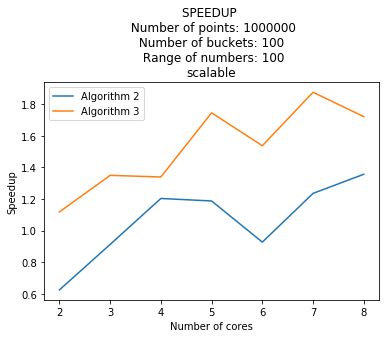

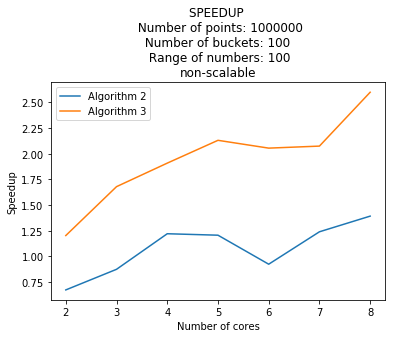

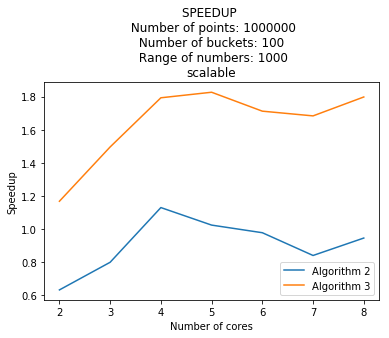

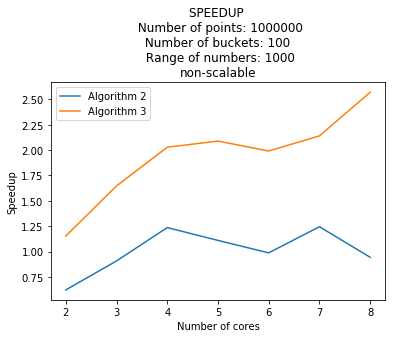

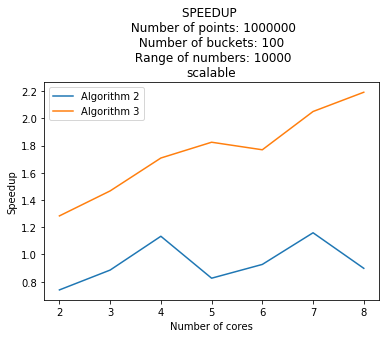

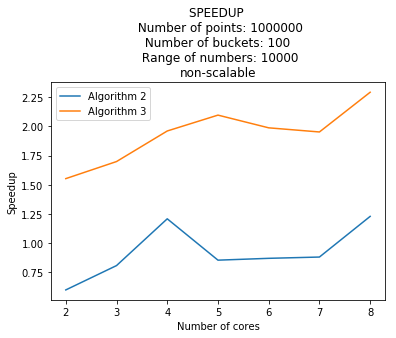

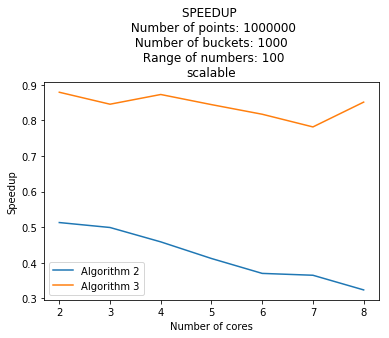

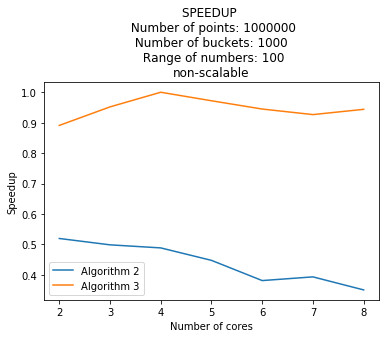

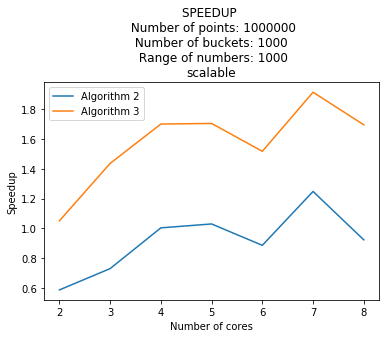

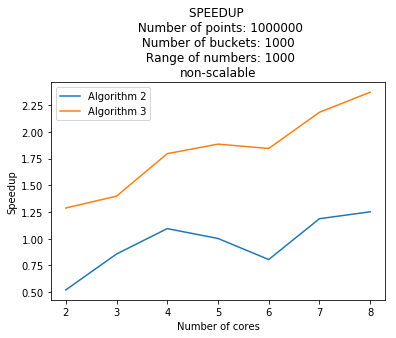

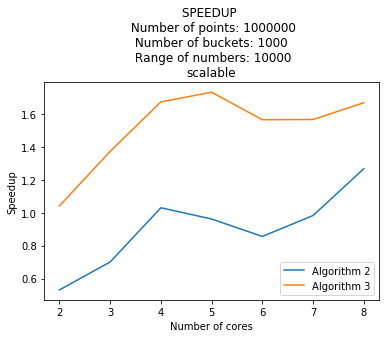

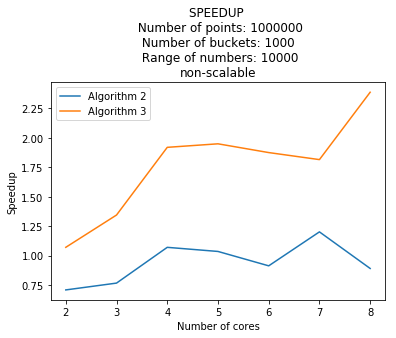

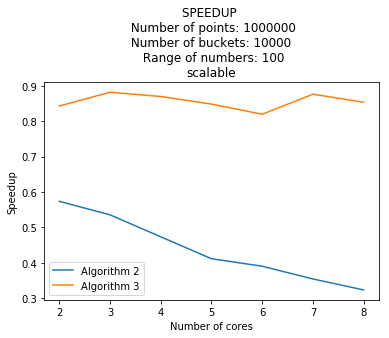

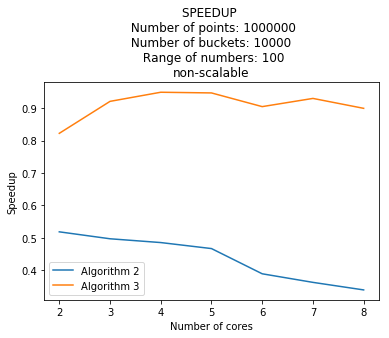

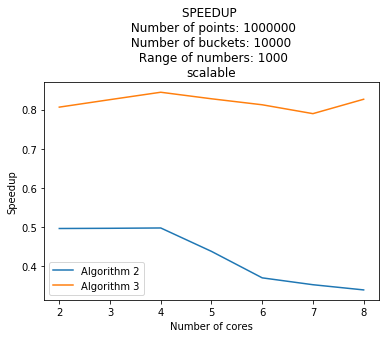

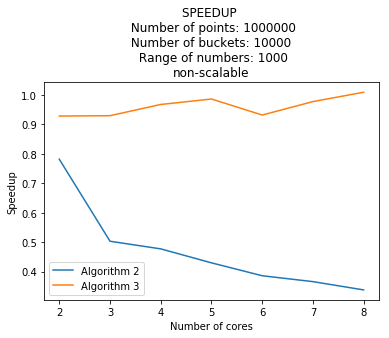

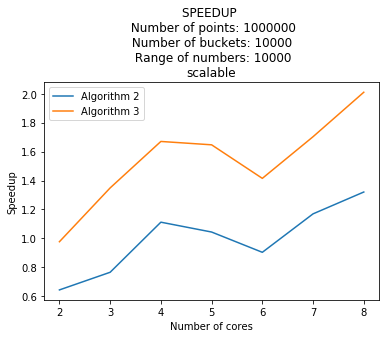

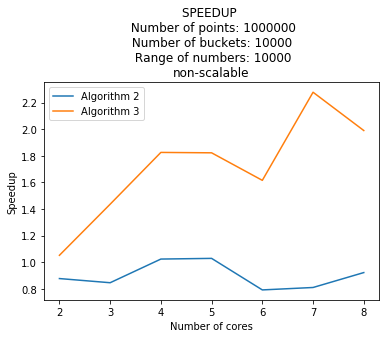

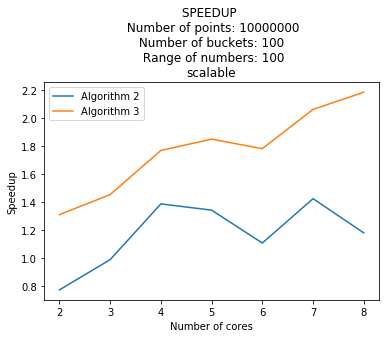

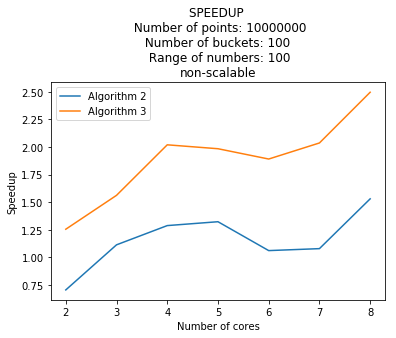

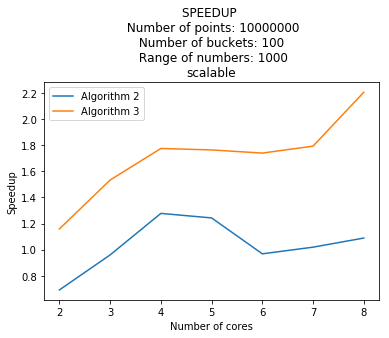

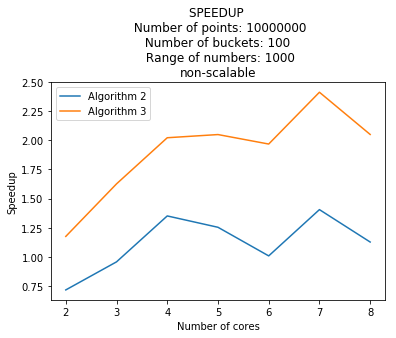

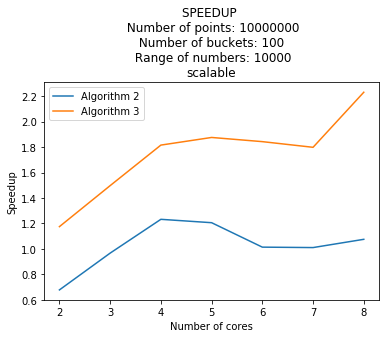

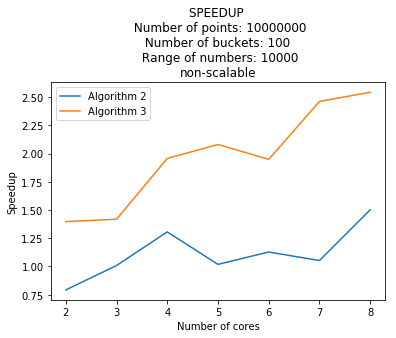

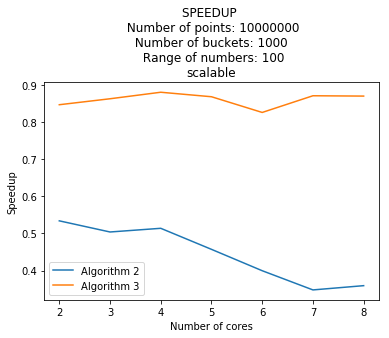

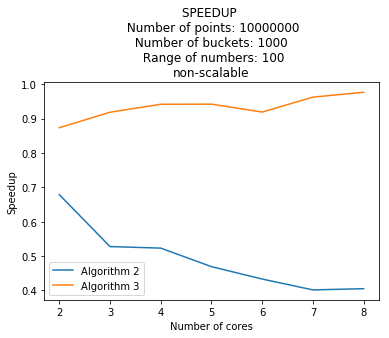

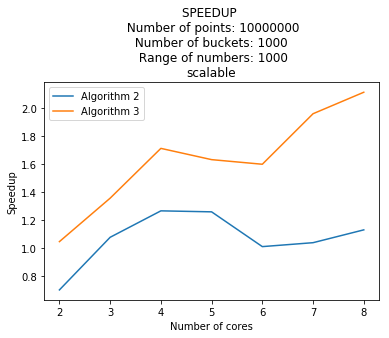

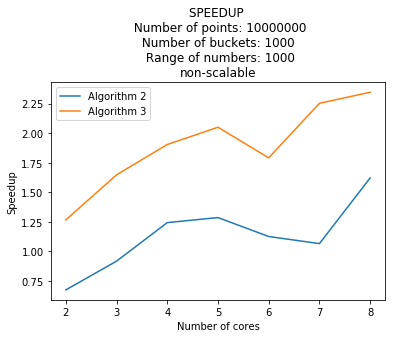

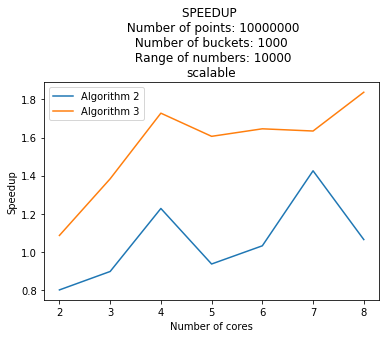

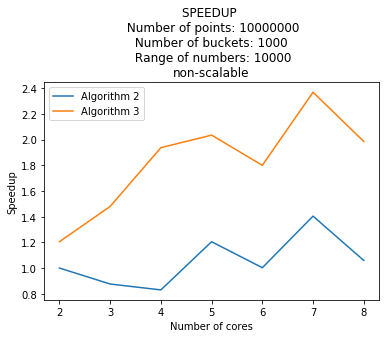

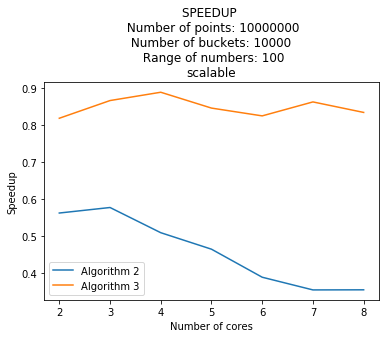

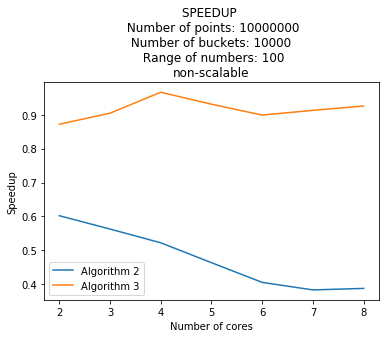

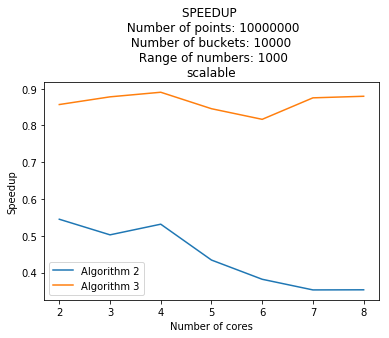

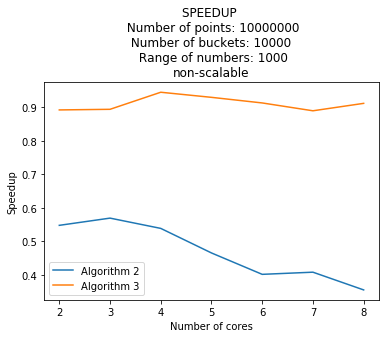

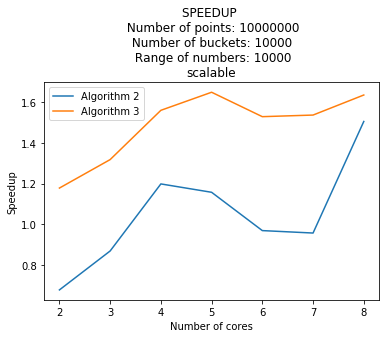

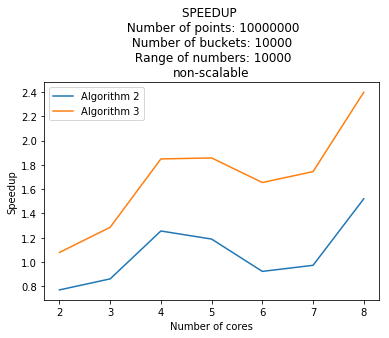

In [121]:
for p in points:
    for b in buckets:
        for r in ranges:
            plot_speedup(file2_scalable, file3_scalable, p, b, r, "scalable")
            plot_speedup(file2_nonscalable, file3_nonscalable, p, b, r, "non-scalable")